<a href="https://colab.research.google.com/github/sandralayas/Knowledge-Graphs-Movie-Recommendation-System/blob/main/Knowledge_Graphs_IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# neo4j graph to Dataframe

In [ ]:
import json
import csv

def create_csv_from_json(relations_file, nodes_file, output_file="output.csv"):
    """
    Reads relations and nodes from JSON files, and creates a CSV file
    with columns "start node", "relation", and "end node".

    Args:
        relations_file (str): Path to the relations JSON file.
        nodes_file (str): Path to the nodes JSON file.
        output_file (str, optional): Path to the output CSV file.
            Defaults to "output.csv".
    """
    try:
        with open(relations_file, 'r', encoding='utf-8-sig') as f_relations, \
             open(nodes_file, 'r', encoding='utf-8-sig') as f_nodes:
            relations_data = json.load(f_relations)
            nodes_data = json.load(f_nodes)
    except FileNotFoundError as e:
        print(f"Error: {e}")
        return
    except json.JSONDecodeError as e:
        print(f"Error: Invalid JSON: {e}")
        return

    # Create a dictionary to store node information using elementId as key for faster lookup
    node_dict = {node['n']['elementId']: node['n'] for node in nodes_data}

    # Prepare data for CSV
    csv_data = []
    for relation_item in relations_data:
        relation = relation_item['r']
        start_node_element_id = relation['startNodeElementId']
        end_node_element_id = relation['endNodeElementId']

        # Check if start and end nodes exist
        if start_node_element_id in node_dict and end_node_element_id in node_dict:
            start_node_name = node_dict[start_node_element_id]['properties'].get('name', 'Unknown')  #handles the cases where a node doesn't have a name.
            end_node_name = node_dict[end_node_element_id]['properties'].get('name', 'Unknown')    #handles the cases where a node doesn't have a name.
            csv_data.append({
                "start node": start_node_name,
                "relation": relation['type'],
                "end node": end_node_name
            })
        else:
            print(f"Warning: Skipping relation with ID {relation['identity']} as start or end node was not found.")

    if not csv_data:
        print("No valid relations found to write to CSV.")
        return

    # Write to CSV
    try:
        with open(output_file, 'w', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=["start node", "relation", "end node"])
            writer.writeheader()
            writer.writerows(csv_data)
        print(f"Successfully wrote data to {output_file}")
    except Exception as e:
        print(f"Error writing to CSV file: {e}")

if __name__ == "__main__":
    relations_file = '/content/relations.json'  # Replace with your actual file name
    nodes_file = '/content/nodes.json'      # Replace with your actual file name
    create_csv_from_json(relations_file, nodes_file)


Successfully wrote data to output.csv


# Trans E

In [ ]:
import json
import csv
import numpy as np
from bs4 import BeautifulSoup
from IPython.display import HTML, display

def create_csv_from_json(relations_file, nodes_file, output_file="output.csv", embedding_dim=100, epochs=500, learning_rate=0.1, margin=1.0):
    """
    Reads relations and nodes from JSON files, and creates a CSV file
    with columns "start node", "relation", "end node", "start node embedding", "relation embedding", "end node embedding".
    Includes a simplified TransE-like embedding training.

    Args:
        relations_file (str): Path to the relations JSON file.
        nodes_file (str): Path to the nodes JSON file.
        output_file (str, optional): Path to the output CSV file.
            Defaults to "output.csv".
        embedding_dim (int, optional): The dimension of the node and relation embeddings.
            Defaults to 100.
        epochs (int, optional): The number of training epochs.
            Defaults to 100.
        learning_rate (float, optional): The learning rate for the optimization.
            Defaults to 0.01.
        margin (float, optional): The margin used in the TransE loss function.
            Defaults to 1.0.
    """
    try:
        with open(relations_file, 'r', encoding='utf-8-sig') as f_relations, \
             open(nodes_file, 'r', encoding='utf-8-sig') as f_nodes:
            relations_data = json.load(f_relations)
            nodes_data = json.load(f_nodes)
    except FileNotFoundError as e:
        print(f"Error: {e}")
        return
    except json.JSONDecodeError as e:
        print(f"Error: Invalid JSON: {e}")
        return

    # 1. Create a dictionary to store node information using elementId as key for faster lookup
    node_dict = {node['n']['elementId']: node['n'] for node in nodes_data}

    # 2. Create a set of unique node IDs and relation types
    unique_node_ids = set()
    unique_relation_types = set()
    for relation_item in relations_data:
        relation = relation_item['r']
        unique_node_ids.add(relation['startNodeElementId'])
        unique_node_ids.add(relation['endNodeElementId'])
        unique_relation_types.add(relation['type'])

    # 3. Create mappings from node IDs and relation types to indices
    node_id_to_index = {node_id: i for i, node_id in enumerate(unique_node_ids)}
    relation_type_to_index = {relation_type: i for i, relation_type in enumerate(unique_relation_types)}
    index_to_node_id = {i: node_id for node_id, i in node_id_to_index.items()} #inverse mapping

    # 4. Initialize node and relation embeddings (TransE)
    node_embeddings = np.random.rand(len(unique_node_ids), embedding_dim)
    relation_embeddings = np.random.rand(len(unique_relation_types), embedding_dim)

    # 5. Training loop
    for epoch in range(epochs):
        total_loss = 0
        for relation_item in relations_data:
            relation = relation_item['r']
            start_node_element_id = relation['startNodeElementId']
            end_node_element_id = relation['endNodeElementId']
            relation_type = relation['type']

            # Get indices
            start_node_index = node_id_to_index[start_node_element_id]
            end_node_index = node_id_to_index[end_node_element_id]
            relation_type_index = relation_type_to_index[relation_type]

            # Get embeddings
            start_node_embedding = node_embeddings[start_node_index]
            end_node_embedding = node_embeddings[end_node_index]
            relation_embedding = relation_embeddings[relation_type_index]

            # Calculate the TransE distance
            distance = np.linalg.norm(start_node_embedding + relation_embedding - end_node_embedding)

            # Generate a corrupted triple for negative sampling
            corrupted_end_node_index = np.random.randint(len(unique_node_ids))
            while corrupted_end_node_index == end_node_index:
                corrupted_end_node_index = np.random.randint(len(unique_node_ids))
            corrupted_end_node_embedding = node_embeddings[corrupted_end_node_index]
            corrupted_distance = np.linalg.norm(start_node_embedding + relation_embedding - corrupted_end_node_embedding)

            # Calculate the TransE loss
            loss = max(0, margin + distance - corrupted_distance)
            total_loss += loss

            # Update embeddings (simplified gradient descent)
            if loss > 0:
                grad_start = 2 * (start_node_embedding + relation_embedding - end_node_embedding)
                grad_relation = 2 * (start_node_embedding + relation_embedding - end_node_embedding)
                grad_end = -2 * (start_node_embedding + relation_embedding - end_node_embedding)
                grad_corrupted_end = 2 * (start_node_embedding + relation_embedding - corrupted_end_node_embedding)

                node_embeddings[start_node_index] -= learning_rate * grad_start
                relation_embeddings[relation_type_index] -= learning_rate * grad_relation
                node_embeddings[end_node_index] -= learning_rate * grad_end
                node_embeddings[corrupted_end_node_index] -= learning_rate * grad_corrupted_end

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.4f}")

    # 6. Prepare data for CSV
    csv_data = []
    for relation_item in relations_data:
        relation = relation_item['r']
        start_node_element_id = relation['startNodeElementId']
        end_node_element_id = relation['endNodeElementId']
        relation_type = relation['type']

        # Check if start and end nodes exist
        if start_node_element_id in node_dict and end_node_element_id in node_dict:
            start_node_name = node_dict[start_node_element_id]['properties'].get('name', 'Unknown')
            end_node_name = node_dict[end_node_element_id]['properties'].get('name', 'Unknown')
            start_node_embedding = node_embeddings[node_id_to_index[start_node_element_id]].tolist()  # Get from trained embeddings
            relation_embedding = relation_embeddings[relation_type_to_index[relation_type]].tolist()      # Get from trained embeddings
            end_node_embedding = node_embeddings[node_id_to_index[end_node_element_id]].tolist()    # Get from trained embeddings

            csv_data.append({
                "start node": start_node_name,
                "relation": relation_type,
                "end node": end_node_name,
                "start node embedding": start_node_embedding,
                "relation embedding": relation_embedding,
                "end node embedding": end_node_embedding
            })
        else:
            print(f"Warning: Skipping relation with ID {relation['identity']} as start or end node was not found.")

    if not csv_data:
        print("No valid relations found to write to CSV.")
        return

    # 7. Write to CSV
    try:
        with open(output_file, 'w', newline='') as csvfile:
            #  Include the new embedding columns in the fieldnames
            fieldnames = ["start node", "relation", "end node", "start node embedding", "relation embedding", "end node embedding"]
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
            writer.writerows(csv_data)
        print(f"Successfully wrote data to {output_file}")
    except Exception as e:
        print(f"Error writing to CSV file: {e}")


if __name__ == "__main__":
    relations_file = 'relations.json'
    nodes_file = 'nodes.json'
    create_csv_from_json(relations_file, nodes_file)


Epoch 1/500, Loss: 470.6083
Epoch 2/500, Loss: 127.8694
Epoch 3/500, Loss: 71.1140
Epoch 4/500, Loss: 42.4777
Epoch 5/500, Loss: 32.1992
Epoch 6/500, Loss: 28.8613
Epoch 7/500, Loss: 15.6599
Epoch 8/500, Loss: 11.1609
Epoch 9/500, Loss: 16.3126
Epoch 10/500, Loss: 19.3671
Epoch 11/500, Loss: 14.2428
Epoch 12/500, Loss: 8.2887
Epoch 13/500, Loss: 13.3942
Epoch 14/500, Loss: 12.0652
Epoch 15/500, Loss: 10.0798
Epoch 16/500, Loss: 11.2762
Epoch 17/500, Loss: 10.5630
Epoch 18/500, Loss: 9.1436
Epoch 19/500, Loss: 7.0792
Epoch 20/500, Loss: 7.5924
Epoch 21/500, Loss: 6.5538
Epoch 22/500, Loss: 2.5486
Epoch 23/500, Loss: 7.3242
Epoch 24/500, Loss: 3.3087
Epoch 25/500, Loss: 2.5721
Epoch 26/500, Loss: 5.0258
Epoch 27/500, Loss: 4.8273
Epoch 28/500, Loss: 9.5441
Epoch 29/500, Loss: 10.9766
Epoch 30/500, Loss: 8.2385
Epoch 31/500, Loss: 8.4797
Epoch 32/500, Loss: 5.1712
Epoch 33/500, Loss: 7.2670
Epoch 34/500, Loss: 6.5955
Epoch 35/500, Loss: 7.6128
Epoch 36/500, Loss: 5.9279
Epoch 37/500, Loss

# Recommender System

In [ ]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import HTML, display
import json  # To safely parse the string embeddings

# Load the output.csv file
try:
    movie_df = pd.read_csv('output.csv')
except FileNotFoundError:
    print("Error: 'output.csv' not found. Please make sure the file is in the same directory as your Colab notebook or provide the correct path.")
    exit()

# Assuming your CSV has columns named 'start node' and 'start node embedding'
# You might need to adjust these names based on your actual CSV structure
if 'start node' not in movie_df.columns or 'start node embedding' not in movie_df.columns:
    print("Error: The CSV file must contain columns named 'start node' and 'start node embedding'. Please check your file.")
    exit()

# Rename columns for clarity
movie_df.rename(columns={'start node': 'title', 'start node embedding': 'embedding_str'}, inplace=True)

# Function to safely parse the string embedding into a list of floats
def parse_embedding(embedding_str):
    try:
        return json.loads(embedding_str)
    except (TypeError, json.JSONDecodeError):
        return None

# Apply the parsing function to the embedding string column
movie_df['embedding'] = movie_df['embedding_str'].apply(parse_embedding)
movie_df.dropna(subset=['embedding'], inplace=True) # Remove rows with unparseable embeddings

def get_similar_movies_df(movie_title, df, top_n=10):
    if movie_title not in df['title'].values:
        return "Movie not found in the database."

    target_embedding = df[df['title'] == movie_title]['embedding'].iloc[0]

    # Calculate cosine similarities
    df['similarity'] = df['embedding'].apply(lambda x: cosine_similarity([target_embedding], [x])[0][0])

    # Sort by similarity and get the top N similar movies (excluding the input movie itself)
    similar_movies_df = df[df['title'] != movie_title].sort_values(by='similarity', ascending=False).head(top_n)
    return similar_movies_df['title'].tolist()

def display_movie_recommendation_interface(movie_list):
    html = """
    <!DOCTYPE html>
    <html>
    <head>
        <title>Nearest Nodes</title>
        <style>
            body { font-family: sans-serif; }
            .input-container { margin-bottom: 20px; }
            label { display: block; margin-bottom: 5px; font-weight: bold; }
            input[type="text"] { width: 300px; padding: 8px; border: 1px solid #ccc; border-radius: 4px; box-sizing: border-box; }
            button { padding: 10px 20px; background-color: #007bff; color: white; border: none; border-radius: 4px; cursor: pointer; font-size: 16px; }
            button:hover { background-color: #0056b3; }
            #recommendations { margin-top: 20px; border: 1px solid #eee; padding: 15px; border-radius: 4px; background-color: #f9f9f9; }
            #recommendations h3 { margin-top: 0; }
            .rank-list { list-style: none; padding: 0; }
            .rank-list li { margin-bottom: 8px; }
        </style>
    </head>
    <body>
        <h2>Nearest Nodes</h2>
        <div class="input-container">
            <label for="movieInput">Enter a movie title:</label>
            <input type="text" id="movieInput" name="movieInput">
            <button onclick="getRecommendations()">Go</button>
        </div>

        <div id="recommendations" style="display: none;">
            <h3>Rank 1 (Top 3 Movies):</h3>
            <ul id="rank1-list" class="rank-list"></ul>
            <h3>Rank 2 (Top 3 by Actor):</h3>
            <ul id="rank2-list" class="rank-list"></ul>
            <h3>Rank 3 (Top 3 by Genre):</h3>
            <ul id="rank3-list" class="rank-list"></ul>
        </div>

        <script>
            const movies = """ + json.dumps(movie_list) + """;
            const getSimilarMoviesJS = (targetMovie, allMovies, topN = 9) => {
                if (!allMovies.some(movie => movie.title === targetMovie)) {
                    return "Movie not found in the database.";
                }

                const targetEmbedding = allMovies.find(movie => movie.title === targetMovie).embedding;

                const withSimilarity = allMovies.map(movie => {
                    if (movie.title === targetMovie || movie.embedding === null || targetEmbedding === null) {
                        return {...movie, similarity: -1}; // Avoid recommending the same movie or comparing with null embeddings
                    }

                    let dotProduct = 0;
                    let normA = 0;
                    let normB = 0;
                    for (let i = 0; i < Math.min(targetEmbedding.length, movie.embedding.length); i++) {
                        dotProduct += targetEmbedding[i] * movie.embedding[i];
                        normA += Math.pow(targetEmbedding[i], 2);
                        normB += Math.pow(movie.embedding[i], 2);
                    }
                    const similarity = dotProduct / (Math.sqrt(normA) * Math.sqrt(normB));
                    return {...movie, similarity: similarity};
                });

                const sortedMovies = withSimilarity.sort((a, b) => b.similarity - a.similarity);
                return sortedMovies.slice(1, topN + 1).map(movie => movie.title);
            };

            function getRecommendations() {
                const movieInput = document.getElementById("movieInput").value;
                const recommendationsDiv = document.getElementById("recommendations");
                const rank1List = document.getElementById("rank1-list");
                const rank2List = document.getElementById("rank2-list");
                const rank3List = document.getElementById("rank3-list");
                rank1List.innerHTML = ""; // Clear previous recommendations
                rank2List.innerHTML = "";
                rank3List.innerHTML = "";

                const similarMovies = getSimilarMoviesJS(movieInput, movies);

                if (typeof similarMovies === 'string') {
                    rank1List.innerHTML = `<li style="color: red;">${similarMovies}</li>`;
                    recommendationsDiv.style.display = "block";
                } else if (similarMovies.length > 0) {
                    recommendationsDiv.style.display = "block";
                    const top3 = similarMovies.slice(0, 3);
                    const next3 = similarMovies.slice(3, 6);
                    const last3 = similarMovies.slice(6, 9);

                    top3.forEach(movie => {
                        const listItem = document.createElement("li");
                        listItem.textContent = movie;
                        rank1List.appendChild(listItem);
                    });

                    next3.forEach(movie => {
                        const listItem = document.createElement("li");
                        listItem.textContent = movie;
                        rank2List.appendChild(listItem);
                    });

                    last3.forEach(movie => {
                        const listItem = document.createElement("li");
                        listItem.textContent = movie;
                        rank3List.appendChild(listItem);
                    });

                } else {
                    rank1List.innerHTML = "<li>No similar movies found.</li>";
                    recommendationsDiv.style.display = "block";
                }
            }
        </script>
    </body>
    </html>
    """
    display(HTML(html))

# Prepare the movie data in a format suitable for the JavaScript function
if 'title' in movie_df.columns and 'embedding' in movie_df.columns:
    movie_data_for_js = movie_df[['title', 'embedding']].to_dict('records')
    # Display the HTML interface only if the DataFrame is properly loaded and processed
    display_movie_recommendation_interface(movie_data_for_js)
else:
    print("Error: Could not prepare movie data for the interface. Ensure 'title' and 'embedding' columns exist.")

In [ ]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import HTML, display
import json  # To safely parse the string embeddings

# Load the output.csv file
try:
    movie_df = pd.read_csv('output.csv')
except FileNotFoundError:
    print("Error: 'output.csv' not found. Please make sure the file is in the same directory as your Colab notebook or provide the correct path.")
    exit()

# Assuming your CSV has columns named 'start node' and 'start node embedding'
# You might need to adjust these names based on your actual CSV structure
if 'start node' not in movie_df.columns or 'start node embedding' not in movie_df.columns:
    print("Error: The CSV file must contain columns named 'start node' and 'start node embedding'. Please check your file.")
    exit()

# Rename columns for clarity
movie_df.rename(columns={'start node': 'title', 'start node embedding': 'embedding_str'}, inplace=True)

# Function to safely parse the string embedding into a list of floats
def parse_embedding(embedding_str):
    try:
        return json.loads(embedding_str)
    except (TypeError, json.JSONDecodeError):
        return None

# Apply the parsing function to the embedding string column
movie_df['embedding'] = movie_df['embedding_str'].apply(parse_embedding)
movie_df.dropna(subset=['embedding'], inplace=True) # Remove rows with unparseable embeddings

def get_similar_movies_df(movie_title, df, top_n=10):
    if movie_title not in df['title'].values:
        return "Movie not found in the database."

    target_embedding = df[df['title'] == movie_title]['embedding'].iloc[0]

    # Calculate cosine similarities
    df['similarity'] = df['embedding'].apply(lambda x: cosine_similarity([target_embedding], [x])[0][0])

    # Sort by similarity and get the top N similar movies (excluding the input movie itself)
    similar_movies = df[df['title'] != movie_title].sort_values(by='similarity', ascending=False).head(top_n)['title'].tolist()

    return similar_movies

def display_movie_recommendation_interface(movie_list):
    html = """
    <!DOCTYPE html>
    <html>
    <head>
        <title>Nearest Nodes</title>
        <style>
            body { font-family: sans-serif; }
            .input-container { margin-bottom: 20px; }
            label { display: block; margin-bottom: 5px; font-weight: bold; }
            input[type="text"] { width: 300px; padding: 8px; border: 1px solid #ccc; border-radius: 4px; box-sizing: border-box; }
            button { padding: 10px 20px; background-color: #007bff; color: white; border: none; border-radius: 4px; cursor: pointer; font-size: 16px; }
            button:hover { background-color: #0056b3; }
            #recommendations { margin-top: 20px; border: 1px solid #eee; padding: 15px; border-radius: 4px; background-color: #f9f9f9; }
            #recommendations h3 { margin-top: 0; }
            #recommendation-list { list-style: none; padding: 0; }
            #recommendation-list li { margin-bottom: 8px; }
        </style>
    </head>
    <body>
        <h2>Nearest Nodes</h2>
        <div class="input-container">
            <label for="movieInput">Enter a movie title:</label>
            <input type="text" id="movieInput" name="movieInput">
            <button onclick="getRecommendations()">Go</button>
        </div>

        <div id="recommendations" style="display: none;">
            <h3>Rank 1:</h3>
            <ul id="recommendation-list"></ul>
        </div>

        <script>
            const movies = """ + json.dumps(movie_list) + """;
            const getSimilarMoviesJS = (targetMovie, allMovies, topN = 10) => {
                if (!allMovies.some(movie => movie.title === targetMovie)) {
                    return "Movie not found in the database.";
                }

                const targetEmbedding = allMovies.find(movie => movie.title === targetMovie).embedding;

                const withSimilarity = allMovies.map(movie => {
                    if (movie.title === targetMovie || movie.embedding === null || targetEmbedding === null) {
                        return {...movie, similarity: -1}; // Avoid recommending the same movie or comparing with null embeddings
                    }

                    let dotProduct = 0;
                    let normA = 0;
                    let normB = 0;
                    for (let i = 0; i < Math.min(targetEmbedding.length, movie.embedding.length); i++) {
                        dotProduct += targetEmbedding[i] * movie.embedding[i];
                        normA += Math.pow(targetEmbedding[i], 2);
                        normB += Math.pow(movie.embedding[i], 2);
                    }
                    const similarity = dotProduct / (Math.sqrt(normA) * Math.sqrt(normB));
                    return {...movie, similarity: similarity};
                });

                const sortedMovies = withSimilarity.sort((a, b) => b.similarity - a.similarity);
                return sortedMovies.slice(1, topN + 1).map(movie => movie.title);
            };

            function getRecommendations() {
                const movieInput = document.getElementById("movieInput").value;
                const recommendationsDiv = document.getElementById("recommendations");
                const recommendationList = document.getElementById("recommendation-list");
                recommendationList.innerHTML = ""; // Clear previous recommendations

                const similarMovies = getSimilarMoviesJS(movieInput, movies);

                if (typeof similarMovies === 'string') {
                    recommendationList.innerHTML = `<li style="color: red;">${similarMovies}</li>`;
                    recommendationsDiv.style.display = "block";
                } else if (similarMovies.length > 0) {
                    similarMovies.forEach(movie => {
                        const listItem = document.createElement("li");
                        listItem.textContent = movie;
                        recommendationList.appendChild(listItem);
                    });
                    recommendationsDiv.style.display = "block";
                } else {
                    recommendationList.innerHTML = "<li>No similar movies found.</li>";
                    recommendationsDiv.style.display = "block";
                }
            }
        </script>
    </body>
    </html>
    """
    display(HTML(html))

# Prepare the movie data in a format suitable for the JavaScript function
if 'title' in movie_df.columns and 'embedding' in movie_df.columns:
    movie_data_for_js = movie_df[['title', 'embedding']].to_dict('records')
    # Display the HTML interface only if the DataFrame is properly loaded and processed
    display_movie_recommendation_interface(movie_data_for_js)
else:
    print("Error: Could not prepare movie data for the interface. Ensure 'title' and 'embedding' columns exist.")

# Initial Embedding for TransE

The code you've provided defines a PyTorch-based implementation of the **TransE** model, which is a model used for **knowledge graph embedding**. In TransE, entities and relations are represented in a continuous vector space, and the relationships between entities are modeled by the scoring function:

\[
\mathbf{h} + \mathbf{r} \approx \mathbf{t}
\]

where:
- \(\mathbf{h}\) is the head entity embedding.
- \(\mathbf{r}\) is the relation embedding.
- \(\mathbf{t}\) is the tail entity embedding.

The model tries to learn embeddings such that for a true triple \((h, r, t)\), the embedding of the head entity plus the relation should be close to the embedding of the tail entity.

### Breakdown of the code:

1. **Class Definition (`TransE`)**:
   - Inheriting from `nn.Module` indicates that this class is a PyTorch model.
   
2. **Constructor (`__init__`)**:
   - `num_entities`: The total number of unique entities in the knowledge graph.
   - `num_relations`: The total number of unique relations in the knowledge graph.
   - `embedding_dim`: The dimension of the embedding space, i.e., the size of the vector representation of each entity and relation.
   
   Inside the constructor:
   - `self.entity_embeddings`: This is an embedding layer for entities, with each entity being represented by a vector of size `embedding_dim`.
   - `self.relation_embeddings`: This is an embedding layer for relations, also of size `embedding_dim`.
   - `self.init_weights()`: This function is called to initialize the embeddings.

3. **Weight Initialization (`init_weights`)**:
   - The function initializes the embeddings with values sampled from a uniform distribution in the range \([-6/\sqrt{k}, 6/\sqrt{k}]\), where \(k\) is the embedding dimension. This is a common initialization method to break symmetry and ensure that the gradients are not too large or too small.
   
   - After initialization, the relation embeddings are normalized using L2 normalization (`nn.functional.normalize`) along the second dimension (`dim=1`). This ensures that all relation embeddings have a unit norm. Normalization often helps in training models where the relative difference between vectors matters, as it prevents the model from focusing on magnitude and instead focuses on the direction of vectors.

4. **Forward Method (`forward`)**:
   - `h`, `r`, `t`: These represent the indices of the head entity, relation, and tail entity, respectively, in the knowledge graph.
   
   In the forward pass:
   - `h_embed`, `r_embed`, and `t_embed` represent the embeddings for the head entity, relation, and tail entity, respectively.
   
   - The scoring function used in TransE is simple: it adds the head embedding (`h_embed`) and the relation embedding (`r_embed`), and then subtracts the tail embedding (`t_embed`). The intuition behind this operation is that for a valid triple \((h, r, t)\), the sum of the head entity and relation should be close to the tail entity in the embedding space, as per the TransE assumption \(\mathbf{h} + \mathbf{r} \approx \mathbf{t}\).

### The purpose of this model:
The TransE model aims to learn embeddings for entities and relations in such a way that for a given relationship, the vector sum of the head entity and the relation vector is close to the tail entity vector. This can be used for tasks like link prediction, where you try to predict missing relations or entities in a knowledge graph.

For example:
- Given a triple `(Paris, isCapitalOf, France)`, TransE should learn embeddings such that the sum of the embedding for "Paris" and the embedding for "isCapitalOf" is close to the embedding for "France". If we remove one of the entities or relations, TransE can help predict the missing entity or relation based on the learned embeddings.

### Potential applications:
- **Knowledge graph completion**: Predicting missing links (e.g., new relationships or missing entities).
- **Recommendation systems**: Using embeddings of items and relationships (like users, items, and interactions) to make recommendations.

The key idea of TransE is to map both entities and relations into a continuous vector space where the relationships between them are preserved in vector arithmetic.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Hyperparameters
embedding_dim = 100  # Size of embeddings (k)
margin = 1.0  # Margin for hinge loss
learning_rate = 0.01
batch_size = 64
num_epochs = 100

# Sample entity and relation sets
entities = ['A', 'B', 'C', 'D', 'E']
relations = ['r1', 'r2']

# Create entity and relation dictionaries
entity2idx = {e: i for i, e in enumerate(entities)}
relation2idx = {r: i for i, r in enumerate(relations)}

num_entities = len(entities)
num_relations = len(relations)

# Define TransE Model
class TransE(nn.Module):
    def __init__(self, num_entities, num_relations, embedding_dim):
        super(TransE, self).__init__()
        self.entity_embeddings = nn.Embedding(num_entities, embedding_dim)
        self.relation_embeddings = nn.Embedding(num_relations, embedding_dim)

        # Initialize embeddings from U(-6/sqrt(k), 6/sqrt(k))
        self.init_weights()

    def init_weights(self):
        bound = 6.0 / np.sqrt(embedding_dim)
        nn.init.uniform_(self.entity_embeddings.weight, -bound, bound)
        nn.init.uniform_(self.relation_embeddings.weight, -bound, bound)

        # Normalize relation embeddings
        self.relation_embeddings.weight.data = nn.functional.normalize(
            self.relation_embeddings.weight.data, p=2, dim=1
        )

    def forward(self, h, r, t):
        h_embed = self.entity_embeddings(h)
        r_embed = self.relation_embeddings(r)
        t_embed = self.entity_embeddings(t)
        return h_embed + r_embed - t_embed  # TransE scoring function

# Create the model
model = TransE(num_entities, num_relations, embedding_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_function = nn.MarginRankingLoss(margin=margin)

# Sample triplets (Example: (head, relation, tail))
triplets = [
    ('A', 'r1', 'B'),
    ('B', 'r2', 'C'),
    ('C', 'r1', 'D'),
    ('D', 'r2', 'E')
]

# Convert triplets to indices
triplets_idx = [(entity2idx[h], relation2idx[r], entity2idx[t]) for h, r, t in triplets]

# Function to generate corrupted triplets
def get_corrupted_triplet(h, r, t):
    corrupt_head = np.random.rand() > 0.5  # Decide to corrupt head or tail
    if corrupt_head:
        h = np.random.randint(0, num_entities)  # Replace head
    else:
        t = np.random.randint(0, num_entities)  # Replace tail
    return h, r, t

# Training loop
for epoch in range(num_epochs):
    np.random.shuffle(triplets_idx)  # Shuffle data
    batch_losses = []

    for i in range(0, len(triplets_idx), batch_size):
        batch = triplets_idx[i:i+batch_size]
        corrupted_batch = [get_corrupted_triplet(h, r, t) for h, r, t in batch]

        # Convert to tensors
        h_batch = torch.tensor([h for h, r, t in batch], dtype=torch.long)
        r_batch = torch.tensor([r for h, r, t in batch], dtype=torch.long)
        t_batch = torch.tensor([t for h, r, t in batch], dtype=torch.long)

        h_corrupt = torch.tensor([h for h, r, t in corrupted_batch], dtype=torch.long)
        t_corrupt = torch.tensor([t for h, r, t in corrupted_batch], dtype=torch.long)

        optimizer.zero_grad()

        # Compute scores
        pos_score = torch.norm(model(h_batch, r_batch, t_batch), p=2, dim=1)
        neg_score = torch.norm(model(h_corrupt, r_batch, t_corrupt), p=2, dim=1)

        # Compute loss
        target = torch.tensor([-1], dtype=torch.long)  # MarginRankingLoss expects -1/1 labels
        loss = loss_function(pos_score, neg_score, target)

        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())

    print(f"Epoch {epoch+1}, Loss: {np.mean(batch_losses):.4f}")

print("Training complete!")


Epoch 1, Loss: 2.2496
Epoch 2, Loss: 0.9951
Epoch 3, Loss: 3.0174
Epoch 4, Loss: 1.1355
Epoch 5, Loss: 2.8729
Epoch 6, Loss: 1.9350
Epoch 7, Loss: 1.0094
Epoch 8, Loss: 1.0582
Epoch 9, Loss: 1.6304
Epoch 10, Loss: 0.9864
Epoch 11, Loss: 0.5652
Epoch 12, Loss: 0.7603
Epoch 13, Loss: 1.3058
Epoch 14, Loss: 0.5669
Epoch 15, Loss: 0.8201
Epoch 16, Loss: 2.0905
Epoch 17, Loss: 1.3964
Epoch 18, Loss: 0.2834
Epoch 19, Loss: 0.0244
Epoch 20, Loss: 0.2500
Epoch 21, Loss: 0.9959
Epoch 22, Loss: 0.5000
Epoch 23, Loss: 0.7500
Epoch 24, Loss: 1.7265
Epoch 25, Loss: 1.0818
Epoch 26, Loss: 0.2500
Epoch 27, Loss: 0.3542
Epoch 28, Loss: 0.7068
Epoch 29, Loss: 0.2937
Epoch 30, Loss: 1.1766
Epoch 31, Loss: 0.9068
Epoch 32, Loss: 0.8516
Epoch 33, Loss: 0.5000
Epoch 34, Loss: 1.3863
Epoch 35, Loss: 0.5288
Epoch 36, Loss: 0.5095
Epoch 37, Loss: 1.3167
Epoch 38, Loss: 0.2500
Epoch 39, Loss: 0.7342
Epoch 40, Loss: 0.9916
Epoch 41, Loss: 0.5237
Epoch 42, Loss: 0.3585
Epoch 43, Loss: 0.6343
Epoch 44, Loss: 0.80

# The Knowlege graph
* Initializing
* Scrapping
* Dataframe Creation
* Mapping
* Recommendation system

Intializing


In [ ]:
!pip install neo4j
!pip install textblob
!pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.5/293.5 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.7 MB/s eta 0:00:00


In [ ]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import os
from IPython.display import FileLink
import re
import time
from os import replace
# from neo4j import GraphDatabase

Scrapping

In [ ]:
title_list=[]
year_list=[]
duration_list=[]
rated_list=[]
actor_list=[]
director_list=[]
rating_list=[]
genre_list=[]
comments_list=[]

In [ ]:
def movie_scrapping(url,title_list,year_list,duration_list,rated_list,actor_list,director_list,rating_list,genre_list,comments_list):#,nlp_score,sentiment_list):
  HEADERS = {'User-Agent': 'Mozilla/5.0 (iPad; CPU OS 12_2 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Mobile/15E148'}
  page = requests.get(url, headers=HEADERS)
  soup = BeautifulSoup(page.content, "html.parser")

  def fetch_movies(soup,title_list,year_list,duration_list,rated_list):
    for i in soup.find_all('a',class_="ipc-title-link-wrapper"):
      title=i.get_text(strip=True)
      title=title[title.index('.')+2:]
      title_list.append(title)

    year_rated_duration=(soup.find_all('span',class_="sc-b189961a-8 kLaxqf dli-title-metadata-item"))

    count=0
    while len(year_list)!=len(title_list):
      try:
        year=year_rated_duration[count].get_text(strip=True)
        duartion=year_rated_duration[count+1].get_text(strip=True)
        rated=year_rated_duration[count+2].get_text(strip=True)

        if year.isnumeric()==True and duartion.isnumeric()==True:
          year_list.append(year)
          duration_list.append('na')
          rated_list.append('na')
          count+=1
        elif year.isnumeric()==True and duartion.isnumeric()!=True:
          for each in (year,duartion,rated):
            if len(str(each))==4:year_list.append(year)
            if 'h' in duartion:duration_list.append(duartion)
            if rated in ['Aprroved','NC-17','TV-MA','G','PG','PG-13','R','Not Rated']:rated_list.append(each)
          count+=3
      except:pass

    # for each in range(len(year_rated_duration)-2):
    #   year=year_rated_duration[each].get_text(strip=True)
    #   duartion=year_rated_duration[each+1].get_text(strip=True)
    #   rated=year_rated_duration[each+2].get_text(strip=True)

    #   if year.isnumeric()==False:pass
    #   else:
    #     year_list.append(year)
    #     if 'h' and 'm' in duartion:duration_list.append(duartion)
    #     else:duration_list.append(None)
    #     if rated in ['Aprroved','NC-17','TV-MA','G','PG','PG-13','R']:rated_list.append(rated)
    #     else:rated_list.append(None)

    return title_list,year_list,duration_list,rated_list

  title_list,year_list,duration_list,rated_list=fetch_movies(soup,title_list,year_list,duration_list,rated_list)

  sub_links=[]

  def get_sublinks(soup,sub_links):
    movies_list=soup.find_all('a',class_='ipc-title-link-wrapper')
    for each in movies_list:
      sub_links.append(each.get('href'))
    return sub_links

  sub_links=get_sublinks(soup,sub_links)

  rooturl='https://www.imdb.com'

  for sub in sub_links:
    url=rooturl+sub
    HEADERS = {'User-Agent': 'Mozilla/5.0 (iPad; CPU OS 12_2 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Mobile/15E148'}
    page = requests.get(url, headers=HEADERS)
    soup = BeautifulSoup(page.content, "html.parser")

    cast=soup.find('a',class_='sc-bfec09a1-1 gCQkeh')
    actor_list.append(cast.get_text(strip=True))

    director=soup.find('a',class_="ipc-metadata-list-item__list-content-item ipc-metadata-list-item__list-content-item--link")
    director_list.append(director.get_text(strip=True))

    rating=soup.find('span',class_="sc-eb51e184-1 cxhhrI")
    if rating==None:rating_list.append(None)
    else:rating_list.append(rating.get_text(strip=True))

    genre=soup.find('span',class_="ipc-chip__text")
    genre_list.append(genre.get_text(strip=True))

    index=(rooturl+sub).index('?ref')

    comment_url=(rooturl+sub)[:index]+'reviews?ref_=tt_urv'
    HEADERS = {'User-Agent': 'Mozilla/5.0 (iPad; CPU OS 12_2 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Mobile/15E148'}
    page1 = requests.get(comment_url, headers=HEADERS)
    soup1 = BeautifulSoup(page1.content, "html.parser")

    temp=[]
    for comment in soup1.find_all('a',class_='title'):
      temp.append(comment.get_text(strip=True))

    comments_list.append(temp)

  lists=[title_list,year_list,duration_list,rated_list,rating_list,director_list]
  for col in lists:
    for row in col:
      if row==None:col[int(col.index(row))]='na'

  return title_list,year_list,duration_list,rated_list,actor_list,director_list,rating_list,genre_list,comments_list#,nlp_score,sentiment_list

In [ ]:
# genre=('action','adventure','animation','biography','comedy','crime')#,'documentary','drama','family','fantasy','film-Noir','game-Show','history','horror','music','musical','mystery','news','reality-TV','romance','sci-Fi','short','sport','talk-Show','thriller','war','western')
# for each in genre:
#   url='https://www.imdb.com/search/title/?title_type=feature&genres='+each

# x=0
# while x<=10:
url='https://www.imdb.com/search/title/?title_type=feature&user_rating='+str(10)+','+str(9)#+str(i/100)+','+str((i/100)-0.50)

f1,f2,f3,f4,f5,f6,f7,f8,f9=movie_scrapping(url,title_list,year_list,duration_list,rated_list,actor_list,director_list,rating_list,genre_list,comments_list)# ,nlp_score,sentiment_list)
title_list+=f1
year_list+=f2
duration_list+=f3
rated_list+=f4
actor_list+=f5
director_list+=f6
rating_list+=f7
genre_list+=f8
comments_list+=f9

  # x+=0.1

# for j in range(10):
#   for i in range(10)
#     url='https://www.imdb.com/search/title/?title_type=feature&user_rating='+str(i)+','+str(i-1)#+str(i/100)+','+str((i/100)-0.50)

#     f1,f2,f3,f4,f5,f6,f7,f8,f9=movie_scrapping(url,title_list,year_list,duration_list,rated_list,actor_list,director_list,rating_list,genre_list,comments_list)# ,nlp_score,sentiment_list)
#     title_list+=f1
#     year_list+=f2
#     duration_list+=f3
#     rated_list+=f4
#     actor_list+=f5
#     director_list+=f6
#     rating_list+=f7
#     genre_list+=f8
#     comments_list+=f9
#     # nlp_score+=f10
#     # sentiment_list+=f11

In [ ]:
# NLP

nlp_score=[]
sentiment_list=[]

from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

for movie in comments_list:
  nlp=0

  vgood=0
  good=0
  bad=0
  vbad=0

  for comment in movie[:20]:
    blob=TextBlob(comment)
    score=blob.sentiment.polarity

    nlp+=score

    if score>0:
      if score>0.5:vgood+=1
      else:good+=1
    elif score<0:
      if score<-0.5:vbad+=1
      else:bad+=1

  if len(movie)==0:divide=1
  else:divide=len(movie)

  nlp_score.append(nlp/divide)

  sentiment=(vbad,bad,good,vgood)
  if max(sentiment)==0:
    sentiment_list.append('Neutral')
  else:
    max_sentiment=max(sentiment)
    if max_sentiment==vgood:sentiment_list.append('Best')
    elif max_sentiment==good:sentiment_list.append('Good')
    elif max_sentiment==bad:sentiment_list.append('Bad')
    else:sentiment_list.append('Worst')


Data Frame Creation

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/sample_data (1).csv')
title_list=list(data['Name'])
year_list=list(data['Year'])
duration_list=list(data['Duration'])
rated_list=list(data['Rated'])
actor_list=list(data['Actor'])
director_list=list(data['Director'])
rating_list=list(data['Rating'])
genre_list=list(data['Genre'])
comments_list=list(data['Comments'])
nlp_score=list(data['NLP Score'])
sentiment_list=list(data['Sentiment'])
data.head()

Name      Genre  Year     Rated  \
0                       The Shawshank Redemption      Drama  1994         R   
1                                  The Godfather      Crime  1972         R   
2                               Schindler's List  Biography  1993         R   
3  The Lord of the Rings: The Return of the King     Action  2003     PG-13   
4                                   12 Angry Men      Crime  1957  Approved   

  Duration  Rating          Actor              Director  \
0   2h 22m     9.3    Tim Robbins        Frank Darabont   
1   2h 55m     9.2  Marlon Brando  Francis Ford Coppola   
2   3h 15m     9.0    Liam Neeson      Steven Spielberg   
3   3h 21m     9.0    Elijah Wood         Peter Jackson   
4   1h 36m     9.0    Henry Fonda          Sidney Lumet   

                                            Comments Sentiment  NLP Score  
0  ["Some birds aren't meant to be caged.", 'An i...      Best   0.218611  
1  ["An offer so good, I couldn't refuse", 'One o...      Best   0.362667  
2  ['Awesome', 'One of the best movies ever made....      Best   0.248000  
3  ['A Timeless Classic', '15 years on... Still t...      Best   0.375391  
4  ['Dont judge by the age!', '12 men in a room. ...      Good   0.288667

In [ ]:
# data = pd.DataFrame()
# data['Name']=title_list
# data['Genre']=genre_list
# data['Year']=year_list
# data['Rated']=rated_list
# data['Duration']=duration_list
# data['Rating']=rating_list
# data['Actor']=actor_list
# data['Director']=director_list
# data['Comments']=comments_list
# data['Sentiment']=sentiment_list
# data['NLP Score']=nlp_score

# data.head()

In [ ]:
data.to_csv('sample_data.csv', index=False)
data = pd.read_csv('sample_data.csv')
print(data.shape)
data = data.drop_duplicates(subset=['Name'], keep='last')
data.to_csv('sample_data.csv', index=False)
print(data.shape)

# download csv
FileLink('sample_data.csv')

# from google.colab import files
# files.download('sample_data.csv')

(214, 11)
(214, 11)


/content/sample_data.csv

Mapping

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt


G = nx.from_pandas_edgelist(data, 'Name', 'Actor')

genre_edges = list(zip(data['Name'], data['Genre']))
G.add_edges_from(genre_edges)

# year_edges = list(zip(data['Name'], data['Year']))
# G.add_edges_from(year_edges)

# rated_edges = list(zip(data['Name'], data['Rated']))
# G.add_edges_from(rated_edges)

# duration_edges = list(zip(data['Name'], data['Duration']))
# G.add_edges_from(duration_edges)

# rating_edges = list(zip(data['Name'], data['Rating']))
# G.add_edges_from(rating_edges)

# actor_edges = list(zip(data['Name'], data['Actor']))
# G.add_edges_from(actor_edges)

director_edges = list(zip(data['Name'], data['Director']))
G.add_edges_from(director_edges)

# comments_edges = list(zip(data['Name'], data['Comments']))
# G.add_edges_from(comments_edges)

# nlp_edges = list(zip(data['Name'], data['NLP Score']))
# G.add_edges_from(nlp_edges)

# sentiment_edges = list(zip(data['Name'], data['Sentiment']))
# G.add_edges_from(sentiment_edges)

In [ ]:
edge_colors = []
for edge in G.edges:
    if edge in genre_edges:
        edge_colors.append('blue')  # Genre edges in blue
    elif edge in director_edges:
        edge_colors.append('green')  # Director edges in green
    else:
        edge_colors.append('red')  # Actor edges in red

node_colors = []
for node in G.nodes(data=True):
    if node == 'Movie':
        node_colors.append('skyblue')  # Movie nodes in skyblue
    elif node == 'Actor':
        node_colors.append('red')  # Actor nodes in red
    elif node == 'Genre':
        node_colors.append('blue')  # Genre nodes in green
    elif node == 'Director':
        node_colors.append('green')  # Director nodes in blue

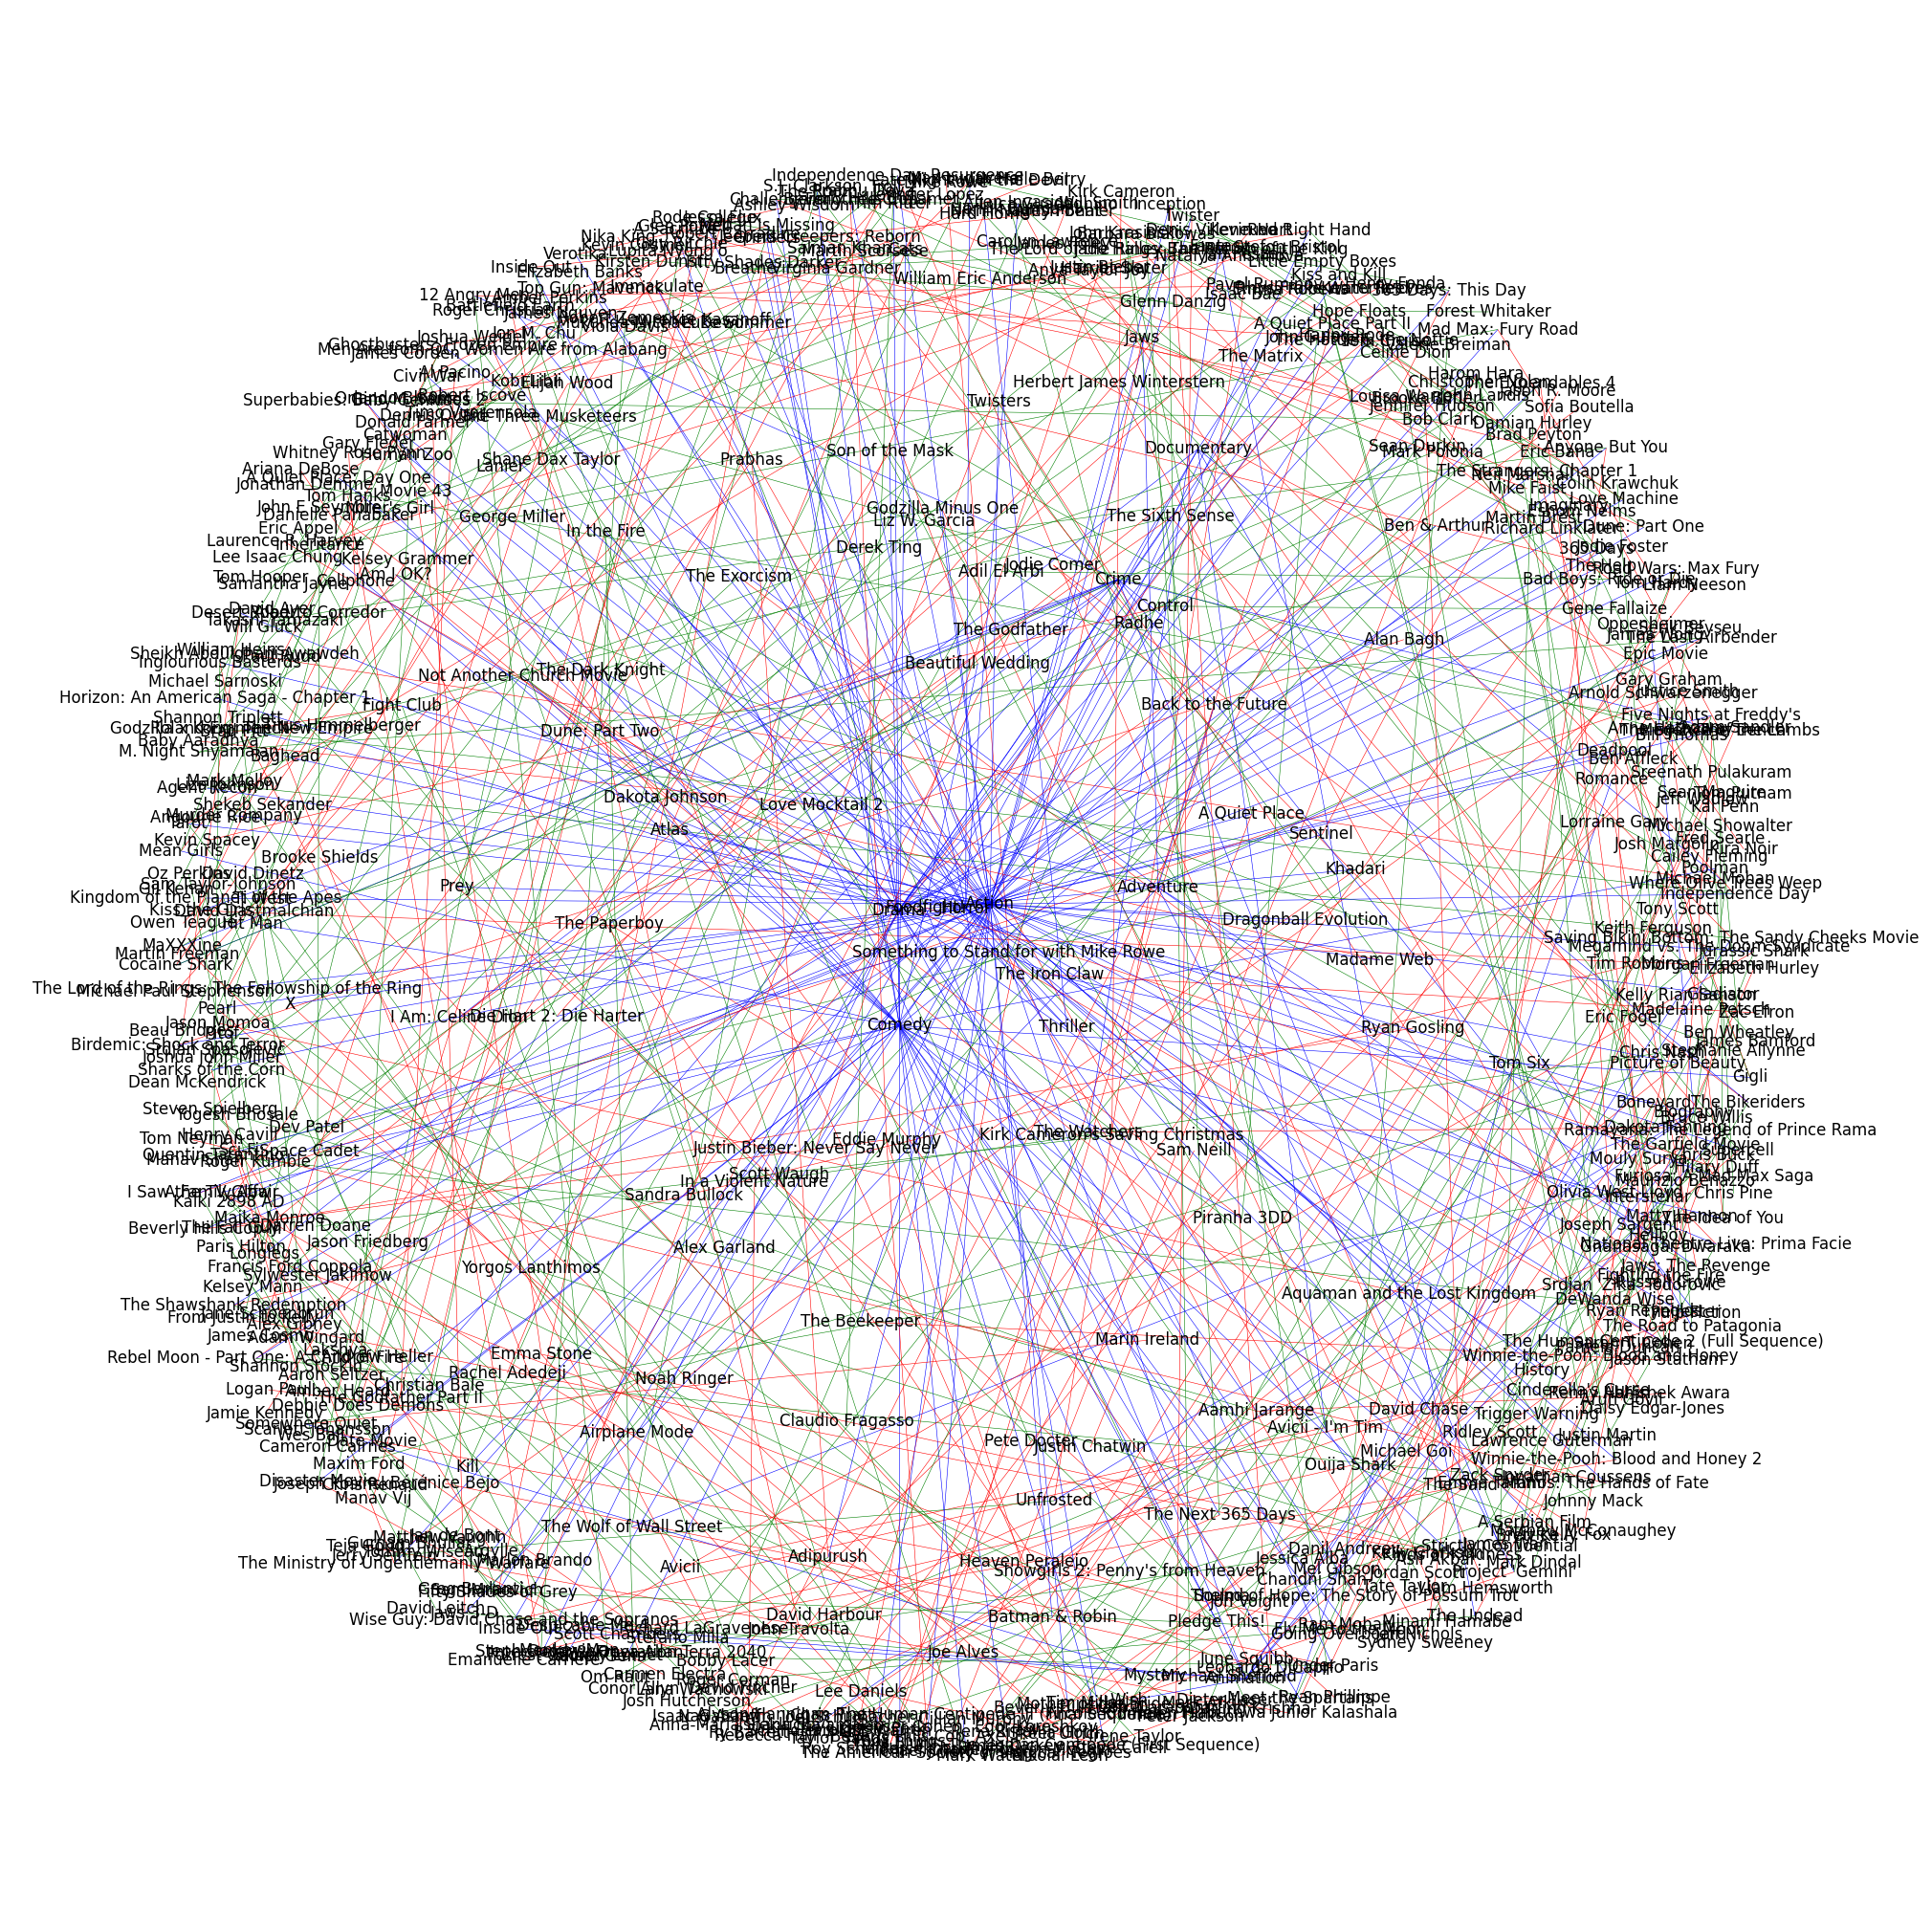

In [ ]:
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G, k=0.8)
nx.draw(G, pos, with_labels=True, node_size=400, width=0.4, edge_color=edge_colors,node_color=node_colors)
plt.show()

Recommendation system

In [ ]:
# Neo4j

from neo4j import GraphDatabase

class Neo4jConnection:

    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)

    def close(self):
        if self.__driver is not None:
            self.__driver.close()

    def query(self, query, parameters=None, db=None):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try:
            session = self.__driver.session(database=db) if db is not None else self.__driver.session()
            response = list(session.run(query, parameters))
        except Exception as e:
            print("Query failed:", e)
        finally:
            if session is not None:
                session.close()
        return response

conn = Neo4jConnection(uri="bolt://54.162.95.224:7687", user="neo4j", pwd="thickness-receptacles-evacuation")

query='''LOAD CSV WITH HEADERS FROM 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQyzVEQHwAfxmFrUoMTTZlZKeQOF8wEtTG2cu6jG-cuhO0z0I5vLkAdpljAQQVQBQwYWKd3MJDUcW1I/pub?gid=2024569982&single=true&output=csv' AS row

// Create or merge the movie nodes
MERGE (m:Movie {name: row.Name, year: row.Year, rated: row.Rated, duration: row.Duration, rating:row.Rating, sentiment:row.Sentiment})

// Create or merge the actor nodes and relationships
WITH row, m
UNWIND split(row.Actor, ':') AS actorName
MERGE (a:Actor {name: actorName})
MERGE (a)-[:ACTED_IN]->(m)

// Create or merge the director nodes and relationships
WITH row, m
MERGE (d:Director {name: row.Director})
MERGE (d)-[:DIRECTED]->(m)

// Create or merge the genre nodes and relationships
WITH row, m
MERGE (g:Genre {name: row.Genre})
MERGE (m)-[:GENRE_IS]->(g)
'''

res=conn.query(query)

query_string = '''MATCH (movie:Movie)
RETURN (movie.name)
'''
movies = conn.query(query_string)

name_html=''
for record in movies:
  temp='\n\t\t\t\t\t<option value="'+record[0]+'">'+record[0]+'</option>'
  name_html+=temp

html_content="""
<!DOCTYPE html>
<html>
<head>
    <title>Movie Database Interface</title>
    <style>
        body {
            font-family: Arial, sans-serif;
            margin: 20px;
            background-color: #f4f4f9;
        }
        h1 {
            color: #333;
        }
        label {
            font-weight: bold;
            display: block;
            margin-top: 20px;
        }
        select {
            width: 100%;
            padding: 10px;
            margin-bottom: 20px;
            border: 1px solid #ddd;
            border-radius: 4px;
            background-color: #fff;
            font-size: 16px;
        }
        input[type="submit"] {
            padding: 10px 20px;
            background-color: #4CAF50;
            color: white;
            border: none;
            border-radius: 4px;
            cursor: pointer;
            font-size: 16px;
        }
        input[type="submit"]:hover {
            background-color: #45a049;
        }
        h2 {
            color: #444;
        }
        ul {
            list-style-type: none;
            padding: 0;
        }
        li {
            background-color: #f9f9f9;
            margin: 5px 0;
            padding: 10px;
            border: 1px solid #ddd;
            border-radius: 4px;
        }
    </style>
</head>
<body>

<h1>Movie Database Interface</h1>
<form id="queryForm" action="/submit" method="post">
    <label for="movie1">Select First Favorite Movie:</label>
    <select id="movie1" name="movie1">
        """+name_html+"""
    </select>

    <label for="movie2">Select Second Favorite Movie:</label>
    <select id="movie2" name="movie2">
        """+name_html+"""
    </select>

    <label for="movie3">Select Third Favorite Movie:</label>
    <select id="movie3" name="movie3">
        """+name_html+"""
    </select>

    <input type="submit" value="Submit">
</form>

{% if movies %}
<div>
    <h2>Selected Movies</h2>
    <ul>
        {% for movie in movies %}
            <li>{{ movie }}</li>
        {% endfor %}
    </ul>
</div>
{% endif %}

{% if recommendations_actor_director %}
<div>
    <h2>Recommendations Based on Actor and Director</h2>
    <ul>
        {% for movie in recommendations_actor_director %}
            <li>{{ movie }}</li>
        {% endfor %}
    </ul>
</div>
{% endif %}

{% if recommendations_genre %}
<div>
    <h2>Recommendations Based on Genre and Sentiment Analysis</h2>
    <ul>
        {% for movie in recommendations_genre %}
            <li>{{ movie }}</li>
        {% endfor %}
    </ul>
</div>
{% endif %}

<script>
    function submitQuery() {
        const movie1 = document.getElementById('movie1').selectedOptions[0].textContent;
        const movie2 = document.getElementById('movie2').selectedOptions[0].textContent;
        const movie3 = document.getElementById('movie3').selectedOptions[0].textContent;
    }
</script>

</body>
</html>
"""

with open('index.html', 'w') as f:
    f.write(html_content)

# my_flask_app/app.py
from flask import Flask, render_template, request

app = Flask(__name__)

@app.route('/')
def index():
    return render_template('index.html')

@app.route('/submit', methods=['POST'])
def submit():
    movie1 = request.form['movie1']
    movie2 = request.form['movie2']
    movie3 = request.form['movie3']

    movies,recommendations_actor_director,recommendations_genre = recomendation_system(movie1, movie2, movie3)

    # Render template with recommendations
    return render_template('index.html',movies=movies, recommendations_actor_director=recommendations_actor_director,recommendations_genre=recommendations_genre)

def recomendation_system(movie1,movie2,movie3):
    fav_genre=[]
    fav_actor=[]
    fav_director=[]

    for movie in (movie1,movie2,movie3):
        query = "MATCH (genre:Genre)<-[s:GENRE_IS]-(movie:Movie {name: '"+movie+"'}) RETURN genre.name"
        result = conn.query(query)
        for each in result:fav_genre.append(each['genre.name'])

        query = "MATCH (actor:Actor)-[s:ACTED_IN]->(movie:Movie {name: '"+movie+"'}) RETURN actor.name"
        result = conn.query(query)
        for each in result:fav_actor.append(each['actor.name'])

        query = "MATCH (director:Director)-[s:DIRECTED]->(movie:Movie {name: '"+movie+"'}) RETURN director.name"
        result = conn.query(query)
        for each in result:fav_director.append(each['director.name'])

    fav_genre=set(fav_genre)
    fav_actor=set(fav_actor)
    fav_director=set(fav_director)

    print('\nFavorites\n')
    print('Genres :',fav_genre)
    print('Actors :',fav_actor)
    print('Directors :',fav_director)

    recommendations_actor_director=[]

    for each in fav_actor:
        query = "MATCH (actor:Actor {name: '"+each+"'})-[s:ACTED_IN]->(movie:Movie) RETURN movie.name"
        result = conn.query(query)
        for each in result:recommendations_actor_director.append(each['movie.name'])

    for each in fav_director:
        query = "MATCH (director:Director {name: '"+each+"'})-[s:DIRECTED]->(movie:Movie) RETURN movie.name"
        result = conn.query(query)
        for each in result:recommendations_actor_director.append(each['movie.name'])

    print('\nRecommendations based on actors and directors\n')
    recommendations_actor_director=set(recommendations_actor_director)
    #for each in recommendations_actor_director:print(each)

    recommendations_genre=[]
    for each in fav_genre:
        query = "MATCH (genre:Genre {name: '"+each+"'})<-[s:GENRE_IS]-(movie:Movie) RETURN movie.name"
        result = conn.query(query)
        for each in result:
          if each['movie.sentiment'] in ['Best','Good']:
            recommendations_genre.append(each['movie.name'])

    print('\nRecommendations based on genre and sentiment analysis\n')
    recommendations_genre=set(recommendations_genre[:10])
    #for each in recommendations_genre:print(each)

    return [movie1,movie2,movie3],recommendations_actor_director, recommendations_genre
if __name__ == '__main__':
    app.run(debug=True, port=8000)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:8000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


# Node2Vec

In [ ]:
node2vecWalk (Graph G' = (V, E, π), Start node u, Length l):

    Initialize walk to [u]
    for (walk_iter = 1 to l):
        curr = walk[−1]
        Vcurr = GetNeighbors(curr, G')
        s = AliasSample(Vcurr, π)
        Append s to walk
    return walk

In [ ]:
Learn_Features (Graph G = (V, E, W)):

    Dimensions -> d
    Walks per node -> r
    Walk length -> l
    Context size -> k
    Return -> p
    In-out -> q

    π = PreprocessModifiedWeights    (G, p, q)
    G' = (V, E, π)

    Initialize walks = 0

    for (iter = 1 to r):
        for (all nodes u ∈ V):
            walk =     node2vecWalk(G', u, l)
            Append walk to walks

    f = StochasticGradientDescent(k, d, walks)
    return f